In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
# import catboost as cb # Optional, install if needed

# Set some display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Set plot style
plt.style.use('ggplot')

In [2]:
train_path = r'D:\GitHubRepos\predict-podcast-listening-time\data\train.csv'
test_path = r'D:\GitHubRepos\predict-podcast-listening-time\data\test.csv'
submission_path = r'D:\GitHubRepos\predict-podcast-listening-time\data\sample_submission.csv'

In [3]:
try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    sample_submission_df = pd.read_csv(submission_path)
    print("Data loaded successfully!")
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure the file paths are correct.")
    # Exit or handle error appropriately
    exit() # Or raise an exception

# Display first few rows
print("\nTrain Data Head:")
print(train_df.head())
print("\nTest Data Head:")
print(test_df.head())
print("\nSample Submission Head:")
print(sample_submission_df.head())

Data loaded successfully!
Train shape: (750000, 12)
Test shape: (250000, 11)

Train Data Head:
   id     Podcast_Name Episode_Title  Episode_Length_minutes       Genre  \
0   0  Mystery Matters    Episode 98                     NaN  True Crime   
1   1    Joke Junction    Episode 26               119.80000      Comedy   
2   2   Study Sessions    Episode 16                73.90000   Education   
3   3   Digital Digest    Episode 45                67.17000  Technology   
4   4      Mind & Body    Episode 86               110.51000      Health   

   Host_Popularity_percentage Publication_Day Publication_Time  \
0                    74.81000        Thursday            Night   
1                    66.95000        Saturday        Afternoon   
2                    69.97000         Tuesday          Evening   
3                    57.22000          Monday          Morning   
4                    80.07000          Monday        Afternoon   

   Guest_Popularity_percentage  Number_of_Ads Episo

In [4]:
print("\nTrain Data Info:")
train_df.info()
print("\nTest Data Info:")
test_df.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memor

In [5]:
print("\nTrain Data Description:")
print(train_df.describe())
print("\nTest Data Description:")
print(test_df.describe(include='object')) # Include categorical features


Train Data Description:
                id  Episode_Length_minutes  Host_Popularity_percentage  \
count 750000.00000            662907.00000                750000.00000   
mean  374999.50000                64.50474                    59.85990   
std   216506.49528                32.96960                    22.87310   
min        0.00000                 0.00000                     1.30000   
25%   187499.75000                35.73000                    39.41000   
50%   374999.50000                63.84000                    60.05000   
75%   562499.25000                94.07000                    79.53000   
max   749999.00000               325.24000                   119.46000   

       Guest_Popularity_percentage  Number_of_Ads  Listening_Time_minutes  
count                 603970.00000   749999.00000            750000.00000  
mean                      52.23645        1.34885                45.43741  
std                       28.45124        1.15113                27.13831  
min 

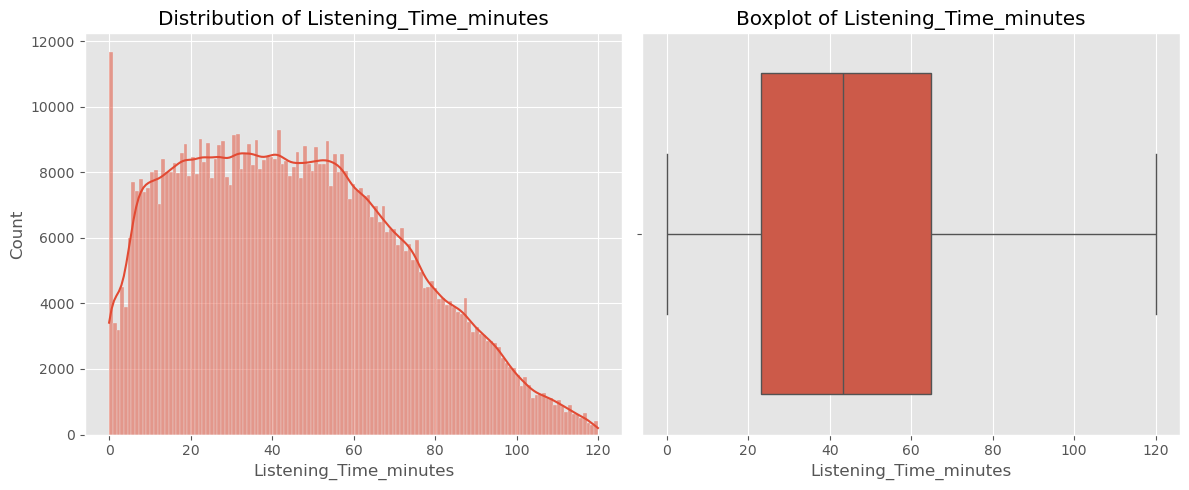

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_df['Listening_Time_minutes'], kde=True)
plt.title('Distribution of Listening_Time_minutes')

plt.subplot(1, 2, 2)
sns.boxplot(x=train_df['Listening_Time_minutes'])
plt.title('Boxplot of Listening_Time_minutes')

plt.tight_layout()
plt.show()

In [7]:
# Calculate skewness
skewness = train_df['Listening_Time_minutes'].skew()
print(f"\nSkewness of Listening_Time_minutes: {skewness:.2f}")


Skewness of Listening_Time_minutes: 0.35


In [8]:
print("\n--- Handling Missing Values ---")

# Episode_Length_minutes: Impute with median
median_length = train_df['Episode_Length_minutes'].median()
train_df['Episode_Length_minutes'].fillna(median_length, inplace=True)
test_df['Episode_Length_minutes'].fillna(median_length, inplace=True) # Use train median
print(f"Imputed 'Episode_Length_minutes' with median: {median_length:.2f}")

# Guest_Popularity_percentage: Impute with median
# Alternative: Consider imputing with 0 if NaN means 'no guest'
median_guest_pop = train_df['Guest_Popularity_percentage'].median()
train_df['Guest_Popularity_percentage'].fillna(median_guest_pop, inplace=True)
test_df['Guest_Popularity_percentage'].fillna(median_guest_pop, inplace=True) # Use train median
print(f"Imputed 'Guest_Popularity_percentage' with median: {median_guest_pop:.2f}")
# # --- Alternative: Impute with 0 ---
# train_df['Guest_Popularity_percentage'].fillna(0, inplace=True)
# test_df['Guest_Popularity_percentage'].fillna(0, inplace=True)
# print("Imputed 'Guest_Popularity_percentage' with 0")
# # ---

# Number_of_Ads: Impute the single missing value in train with median
median_ads = train_df['Number_of_Ads'].median() # Calculated on non-missing values
train_df['Number_of_Ads'].fillna(median_ads, inplace=True)
# Test set has no missing values for this column based on info()
print(f"Imputed 'Number_of_Ads' (train) with median: {median_ads:.1f}")


# Verify imputation
print("\nMissing values after imputation (Train):")
print(train_df.isnull().sum())
print("\nMissing values after imputation (Test):")
print(test_df.isnull().sum())


--- Handling Missing Values ---
Imputed 'Episode_Length_minutes' with median: 63.84
Imputed 'Guest_Popularity_percentage' with median: 53.58
Imputed 'Number_of_Ads' (train) with median: 1.0

Missing values after imputation (Train):
id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64

Missing values after imputation (Test):
id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads       

C:\Users\wjw20\AppData\Local\Temp\ipykernel_19880\1803184682.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Episode_Length_minutes'].fillna(median_length, inplace=True)
C:\Users\wjw20\AppData\Local\Temp\ipykernel_19880\1803184682.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav


--- Analyzing Numerical Features ---

Number_of_Ads value counts (Top 10):
Number_of_Ads
0.00000      217592
1.00000      214070
3.00000      160173
2.00000      158156
103.25000         2
53.37000          1
103.91000         1
103.00000         1
53.42000          1
103.75000         1
Name: count, dtype: int64

Number_of_Ads description:
count   750000.00000
mean         1.34885
std          1.15113
min          0.00000
25%          0.00000
50%          1.00000
75%          2.00000
max        103.91000
Name: Number_of_Ads, dtype: float64
99.9th percentile of Number_of_Ads: 3.0
Capping Number_of_Ads at 3.0


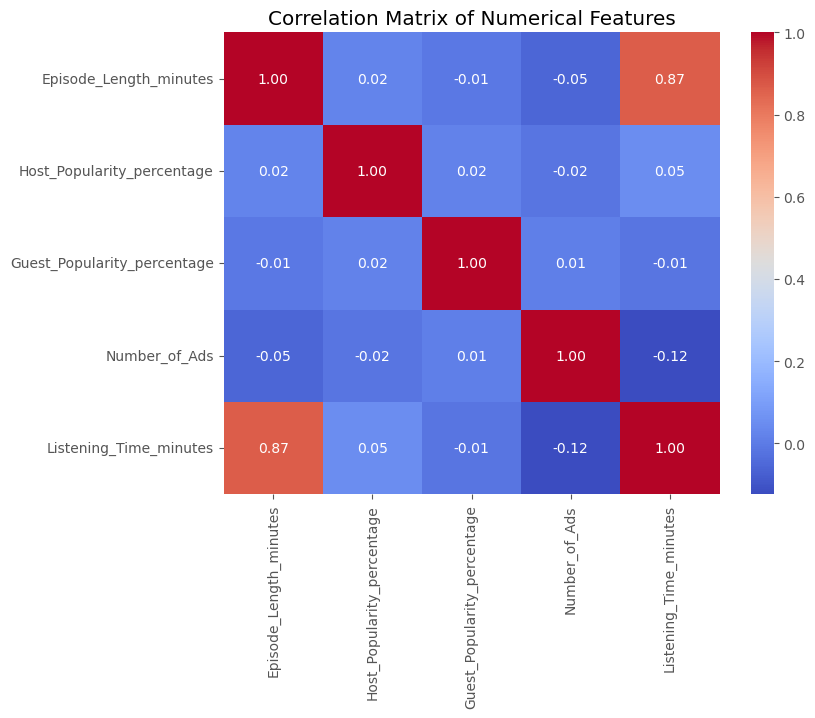

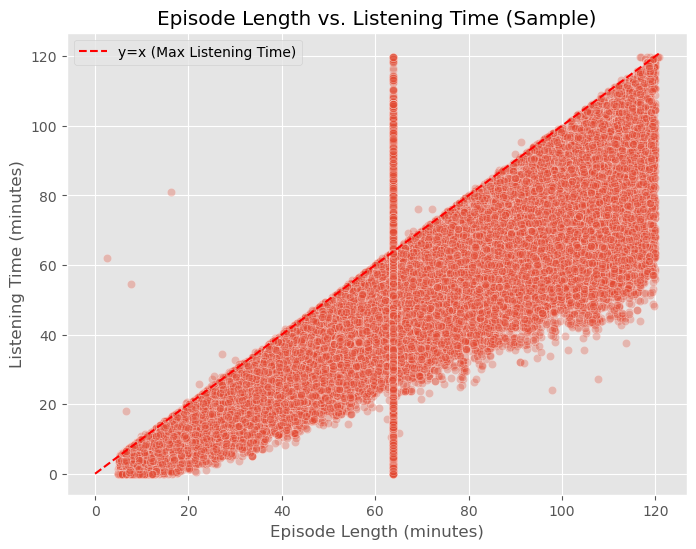

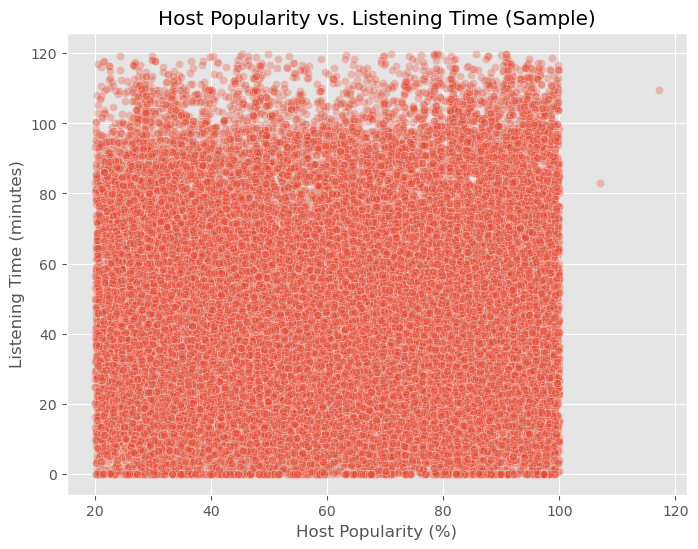

In [9]:
print("\n--- Analyzing Numerical Features ---")

# Check for outliers in Number_of_Ads
print("\nNumber_of_Ads value counts (Top 10):")
print(train_df['Number_of_Ads'].value_counts().head(10))
print("\nNumber_of_Ads description:")
print(train_df['Number_of_Ads'].describe())
# The max value 103.91 looks like an error or extreme outlier.
# Let's cap it or investigate further. Capping at a reasonable value (e.g., 99th percentile) might be wise.
ads_cap = train_df['Number_of_Ads'].quantile(0.999) # Check 99.9th percentile
print(f"99.9th percentile of Number_of_Ads: {ads_cap}")
# If the cap is much lower than max, consider capping
max_ads = train_df['Number_of_Ads'].max()
if max_ads > ads_cap * 2 and max_ads > 10: # Heuristic check for extreme outlier
    print(f"Capping Number_of_Ads at {ads_cap}")
    train_df['Number_of_Ads'] = train_df['Number_of_Ads'].clip(upper=ads_cap)
    test_df['Number_of_Ads'] = test_df['Number_of_Ads'].clip(upper=ads_cap) # Apply same cap to test

# Define numerical features (excluding id and target)
numerical_features = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']

# Correlation heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = train_df[numerical_features + ['Listening_Time_minutes']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Scatter plot: Episode Length vs. Listening Time
plt.figure(figsize=(8, 6))
# Use a sample to avoid overplotting if the dataset is very large
sample_df = train_df.sample(n=min(50000, len(train_df)), random_state=42)
sns.scatterplot(data=sample_df, x='Episode_Length_minutes', y='Listening_Time_minutes', alpha=0.3)
plt.title('Episode Length vs. Listening Time (Sample)')
plt.xlabel('Episode Length (minutes)')
plt.ylabel('Listening Time (minutes)')
# Add a line y=x for reference (maximum possible listening time is episode length)
max_val = max(sample_df['Episode_Length_minutes'].max(), sample_df['Listening_Time_minutes'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y=x (Max Listening Time)')
plt.legend()
plt.show()

# Scatter plot: Host Popularity vs. Listening Time
plt.figure(figsize=(8, 6))
sns.scatterplot(data=sample_df, x='Host_Popularity_percentage', y='Listening_Time_minutes', alpha=0.3)
plt.title('Host Popularity vs. Listening Time (Sample)')
plt.xlabel('Host Popularity (%)')
plt.ylabel('Listening Time (minutes)')
plt.show()


--- Analyzing Categorical Features ---

Unique value counts for categorical features (Train):
- Podcast_Name: 48
- Episode_Title: 100
- Genre: 10
Genre
Sports        87606
Technology    86256
True Crime    85059
Lifestyle     82461
Comedy        81453
Business      80521
Health        71416
News          63385
Music         62743
Education     49100
Name: count, dtype: int64
----------
- Publication_Day: 7
Publication_Day
Sunday       115946
Monday       111963
Friday       108237
Wednesday    107886
Thursday     104360
Saturday     103505
Tuesday       98103
Name: count, dtype: int64
----------
- Publication_Time: 4
Publication_Time
Night        196849
Evening      195778
Afternoon    179460
Morning      177913
Name: count, dtype: int64
----------
- Episode_Sentiment: 3
Episode_Sentiment
Neutral     251291
Negative    250116
Positive    248593
Name: count, dtype: int64
----------

Sample Episode Titles:
['Episode 98' 'Episode 26' 'Episode 16' 'Episode 45' 'Episode 86'
 'Episode 19' '

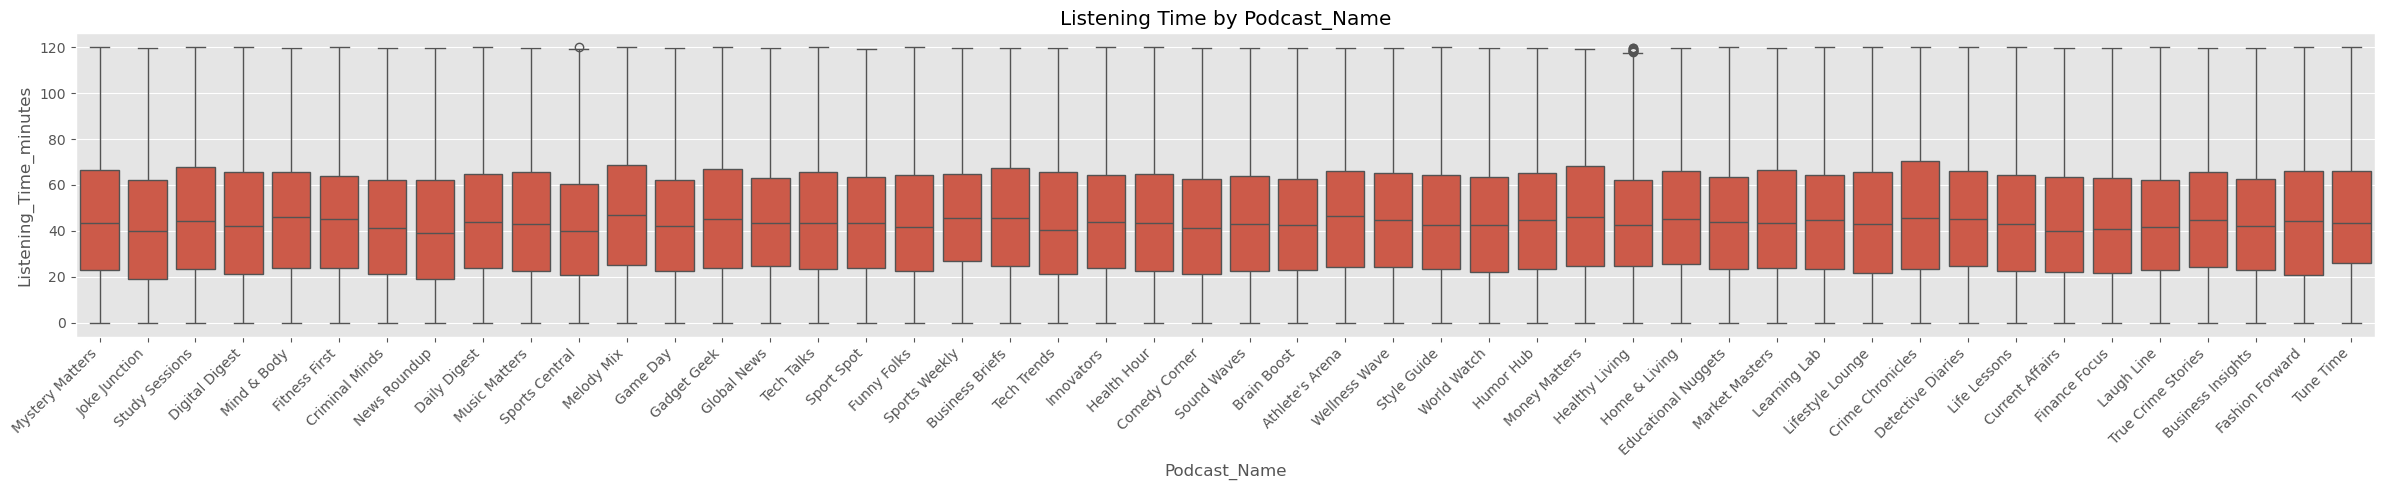

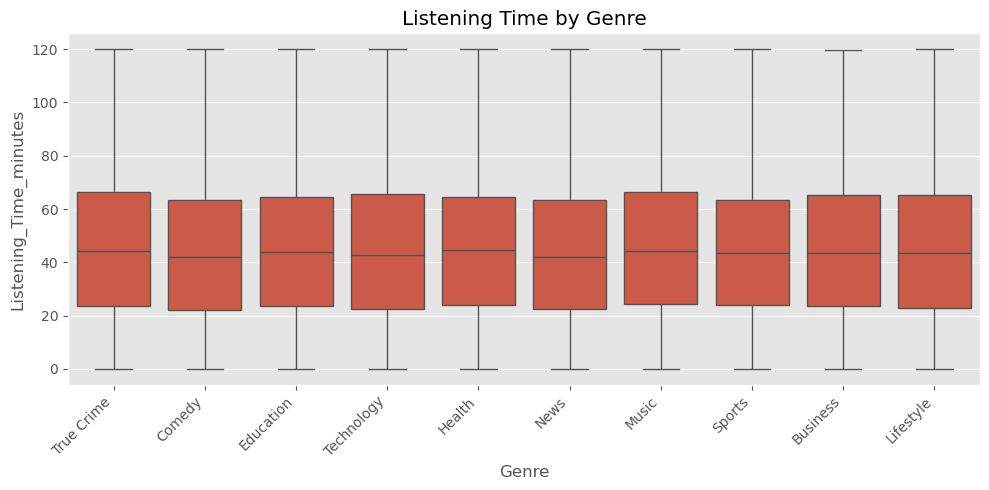

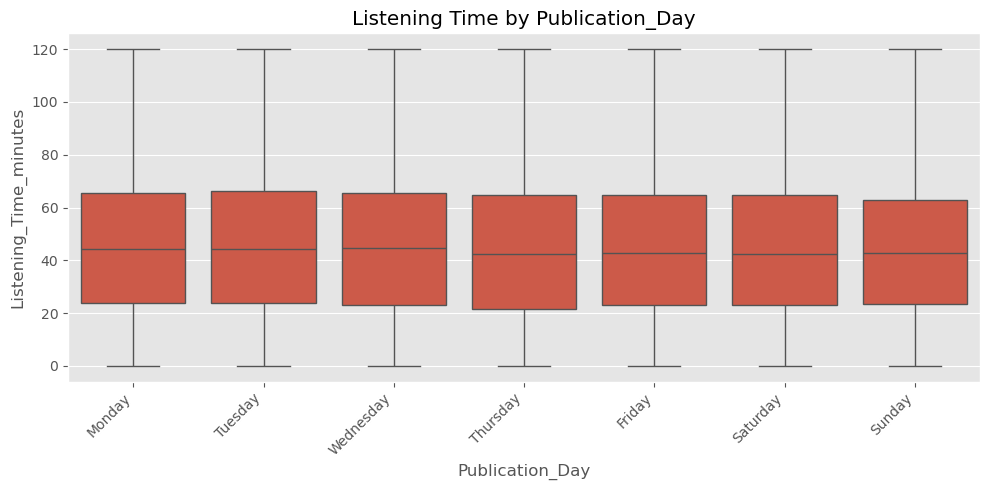

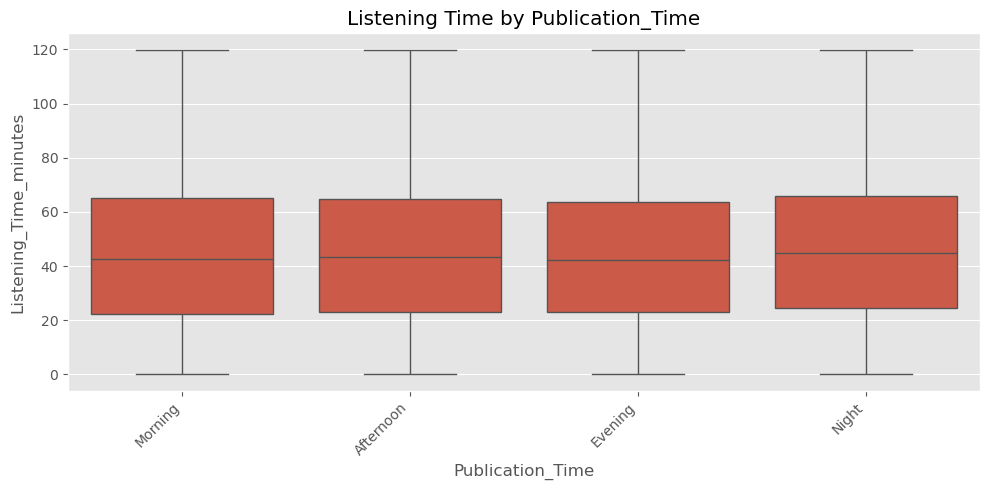

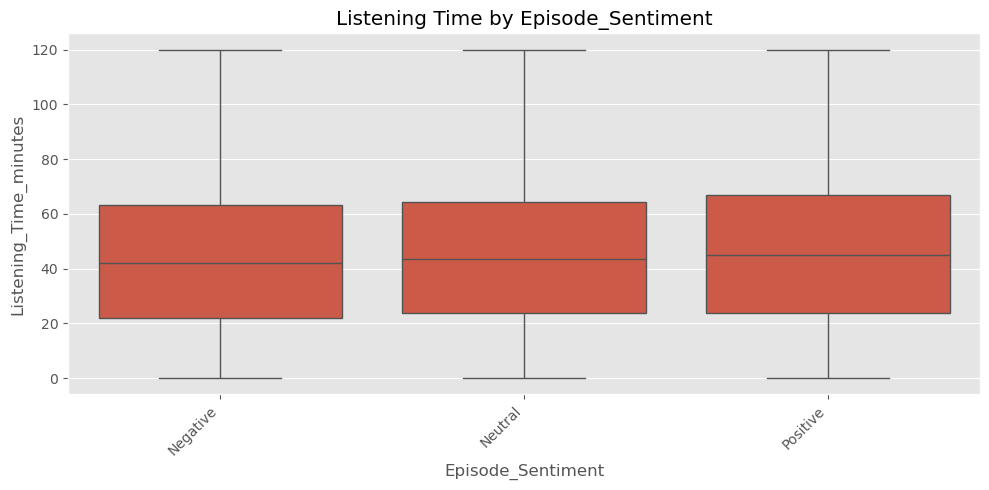

In [10]:
print("\n--- Analyzing Categorical Features ---")

categorical_features = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day',
                        'Publication_Time', 'Episode_Sentiment']

print("\nUnique value counts for categorical features (Train):")
for col in categorical_features:
    print(f"- {col}: {train_df[col].nunique()}")
    if train_df[col].nunique() < 15: # Show counts for low cardinality features
        print(train_df[col].value_counts())
        print("-" * 10)

# --- Feature Engineering Idea: Extract Episode Number ---
# Check if Episode_Title format is consistent
print("\nSample Episode Titles:")
print(train_df['Episode_Title'].unique()[:10]) # Show some unique titles
# Looks like "Episode XXX", let's extract the number
train_df['Episode_Number'] = train_df['Episode_Title'].str.extract('(\d+)').astype(float) # Extract digits, convert to float
test_df['Episode_Number'] = test_df['Episode_Title'].str.extract('(\d+)').astype(float)

# Check if extraction worked and handle potential NaNs if format varies
print("\nCheck Episode_Number extraction (NaN count):")
print("Train:", train_df['Episode_Number'].isnull().sum())
print("Test:", test_df['Episode_Number'].isnull().sum())
# If there are NaNs, decide how to fill them (e.g., with median or 0)
if train_df['Episode_Number'].isnull().any():
    median_ep_num = train_df['Episode_Number'].median()
    train_df['Episode_Number'].fillna(median_ep_num, inplace=True)
    test_df['Episode_Number'].fillna(median_ep_num, inplace=True) # Use train median
    print(f"Filled NaN Episode_Number with median: {median_ep_num}")

# Now add 'Episode_Number' to numerical features and remove 'Episode_Title' from categorical
numerical_features.append('Episode_Number')
categorical_features.remove('Episode_Title')
print("\nUpdated numerical features:", numerical_features)
print("Updated categorical features:", categorical_features)
# --- End Feature Engineering Idea ---


# Boxplots for categorical features vs Listening Time
for col in categorical_features:
    # Skip high cardinality features for boxplots or use sampling
    if train_df[col].nunique() > 50:
        print(f"Skipping boxplot for high cardinality feature: {col}")
        continue

    plt.figure(figsize=(max(10, train_df[col].nunique()*0.5), 5)) # Adjust size based on cardinality
    # Order days and times if possible
    if col == 'Publication_Day':
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        try:
            sns.boxplot(data=train_df, x=col, y='Listening_Time_minutes', order=day_order)
        except:
            sns.boxplot(data=train_df, x=col, y='Listening_Time_minutes') # Fallback
    elif col == 'Publication_Time':
        time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
        try:
            sns.boxplot(data=train_df, x=col, y='Listening_Time_minutes', order=time_order)
        except:
            sns.boxplot(data=train_df, x=col, y='Listening_Time_minutes') # Fallback
    elif col == 'Episode_Sentiment':
        sentiment_order = ['Negative', 'Neutral', 'Positive']
        try:
            sns.boxplot(data=train_df, x=col, y='Listening_Time_minutes', order=sentiment_order)
        except:
            sns.boxplot(data=train_df, x=col, y='Listening_Time_minutes') # Fallback
    else:
        sns.boxplot(data=train_df, x=col, y='Listening_Time_minutes')

    plt.title(f'Listening Time by {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [11]:
print("\n--- 创建插补指示特征 ---") # Output in Chinese
# 简要重新加载数据以获取原始 NaN 位置
train_orig_na = pd.read_csv(train_path, usecols=['Episode_Length_minutes', 'Guest_Popularity_percentage'])
test_orig_na = pd.read_csv(test_path, usecols=['Episode_Length_minutes', 'Guest_Popularity_percentage'])

# 创建标记 (如果被插补则为 1，否则为 0)
train_df['Length_Imputed'] = train_orig_na['Episode_Length_minutes'].isnull().astype(int)
test_df['Length_Imputed'] = test_orig_na['Episode_Length_minutes'].isnull().astype(int)
train_df['Guest_Pop_Imputed'] = train_orig_na['Guest_Popularity_percentage'].isnull().astype(int)
test_df['Guest_Pop_Imputed'] = test_orig_na['Guest_Popularity_percentage'].isnull().astype(int)

print("创建了 'Length_Imputed' 和 'Guest_Pop_Imputed' 特征。") # Output in Chinese
print("插补的长度数量 (训练集):", train_df['Length_Imputed'].sum()) # Output in Chinese
print("插补的嘉宾受欢迎度数量 (训练集):", train_df['Guest_Pop_Imputed'].sum()) # Output in Chinese

# 将这些添加到我们的数值特征列表中 (它们技术上是数值 0/1)
numerical_features.extend(['Length_Imputed', 'Guest_Pop_Imputed'])
# 清理临时数据帧
del train_orig_na, test_orig_na


--- 创建插补指示特征 ---
创建了 'Length_Imputed' 和 'Guest_Pop_Imputed' 特征。
插补的长度数量 (训练集): 87093
插补的嘉宾受欢迎度数量 (训练集): 146030


In [12]:
print("\n--- 设置预处理管道 ---") # Output in Chinese

# 定义最终特征列表
target = 'Listening_Time_minutes'
# 用于建模的特征 (确保列表是最新的)
numerical_features = ['Episode_Length_minutes', 'Host_Popularity_percentage',
                      'Guest_Popularity_percentage', 'Number_of_Ads', 'Episode_Number',
                      'Length_Imputed', 'Guest_Pop_Imputed']
categorical_features = ['Podcast_Name', 'Genre', 'Publication_Day',
                        'Publication_Time'] # 暂时排除 Sentiment，单独处理
ordinal_features = ['Episode_Sentiment']
sentiment_order = ['Negative', 'Neutral', 'Positive'] # 定义顺序

# 合并所有预测变量列
features = numerical_features + categorical_features + ordinal_features

X = train_df[features].copy() # 使用 copy 以避免 SettingWithCopyWarning
y = train_df[target]
X_test = test_df[features].copy()

# --- 创建预处理管道 ---

# 数值特征管道：缩放
# 插补之前已完成，否则在此处添加 SimpleImputer
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 标准分类特征管道：One-Hot 编码
# 插补之前已完成，否则在此处添加 SimpleImputer(strategy='most_frequent')
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False 以便后续更容易处理
])

# 顺序特征管道：Ordinal 编码
# 插补之前已完成，否则在此处添加 SimpleImputer(strategy='most_frequent')
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[sentiment_order])) # 指定顺序
])

# --- 创建 ColumnTransformer ---
# 这会将正确的转换器应用于每种列类型
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
    ],
    remainder='passthrough' # 保留未指定的任何列 (这里应该没有)
)

# --- 拟合预处理器并转换数据 ---
# 仅在训练数据上拟合
print("在训练数据上拟合预处理器...") # Output in Chinese
preprocessor.fit(X)

# 转换训练和测试数据
print("转换训练数据...") # Output in Chinese
X_processed = preprocessor.transform(X)
print("转换测试数据...") # Output in Chinese
X_test_processed = preprocessor.transform(X_test)

# 获取转换后的特征名称 (对解释很重要)
try:
    # 从每个转换器步骤获取特征名称
    num_feature_names = numerical_features
    cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
    ord_feature_names = preprocessor.named_transformers_['ord'].get_feature_names_out(ordinal_features).tolist()
    # 合并所有名称
    feature_names_out = num_feature_names + cat_feature_names + ord_feature_names
    print(f"\n处理后的特征形状 (训练集): {X_processed.shape}") # Output in Chinese
    print(f"处理后的特征数量: {len(feature_names_out)}") # Output in Chinese
    # print("特征名称示例:", feature_names_out[:10] + feature_names_out[-5:]) # 打印示例，Output in Chinese
except Exception as e:
    print(f"无法获取特征名称: {e}") # Output in Chinese
    feature_names_out = None # 备选方案

# 转换为 DataFrame 以便更容易检查 (可选)
X_processed_df = pd.DataFrame(X_processed, columns=feature_names_out, index=X.index)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names_out, index=X_test.index)
print("\n处理后的训练数据头部:") # Output in Chinese
print(X_processed_df.head())


--- 设置预处理管道 ---
在训练数据上拟合预处理器...
转换训练数据...
转换测试数据...

处理后的特征形状 (训练集): (750000, 77)
处理后的特征数量: 77

处理后的训练数据头部:
   Episode_Length_minutes  Host_Popularity_percentage  \
0                -0.01895                     0.65361   
1                 1.78638                     0.30998   
2                 0.30559                     0.44201   
3                 0.08847                    -0.11542   
4                 1.48668                     0.88358   

   Guest_Popularity_percentage  Number_of_Ads  Episode_Number  Length_Imputed  \
0                      0.04237       -1.21326         1.65758         2.75889   
1                      0.91835        0.58696        -0.90601        -0.36246   
2                     -1.70450       -1.21326        -1.26206        -0.36246   
3                      1.02603        0.58696        -0.22951        -0.36246   
4                      0.24208        1.48707         1.23032        -0.36246   

   Guest_Pop_Imputed  Podcast_Name_Athlete's Arena  Podcast_N

#### XGBoost

In [13]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import time # 用于计时

print("--- XGBoost Baseline with GPU and Hyperparameter Search ---")

--- XGBoost Baseline with GPU and Hyperparameter Search ---


In [14]:
# --- 1. 定义参数搜索空间 ---
# (可以根据需要调整这些范围)
param_dist = {
    'n_estimators': [100, 200, 500, 1000, 1500], # 树的数量
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2], # 学习率
    'max_depth': [3, 5, 7, 9, 11], # 树的最大深度
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # 构建每棵树时样本的抽样比率
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # 构建每棵树时特征的抽样比率
    'gamma': [0, 0.1, 0.2, 0.3], # L1 正则化项
    'reg_alpha': [0, 0.01, 0.1, 1], # L1 正则化项 (别名)
    'reg_lambda': [0.1, 0.5, 1, 1.5, 2], # L2 正则化项
    # 注意: XGBoost GPU ('gpu_hist') 通常对 'min_child_weight' 不太敏感，可以不调或使用默认值
}

In [15]:
# --- 2. 初始化 XGBoost 回归器 (启用 GPU) ---
# 确保设置 tree_method='gpu_hist' 来使用 GPU
# 如果你的 XGBoost 没有 GPU 支持或未检测到 GPU，这里会报错
try:
    xgb_reg = xgb.XGBRegressor(
        objective='reg:squarederror', # 回归任务的目标函数
        tree_method='gpu_hist',       # 使用 GPU 加速！
        random_state=42,              # 设置随机种子以便复现
        # device='cuda' # 或者 'cuda:0' 如果有多个 GPU，通常 XGBoost 会自动检测
    )
    print("XGBRegressor initialized with tree_method='gpu_hist'.")
except Exception as e:
    print(f"Error initializing XGBoost with GPU: {e}")
    print("Falling back to CPU ('hist' or 'auto'). GPU acceleration might not be available.")
    xgb_reg = xgb.XGBRegressor(
        objective='reg:squarederror',
        tree_method='hist', # 或者 'auto'，使用基于 CPU 的直方图算法
        random_state=42
    )

XGBRegressor initialized with tree_method='gpu_hist'.


In [16]:
# --- 3. 设置 RandomizedSearchCV ---
# n_iter 控制尝试的参数组合数量
# cv 是交叉验证的折数
# scoring 使用 'neg_root_mean_squared_error' (因为 sklearn 旨在最大化分数)
# n_jobs = -1 使用所有 CPU 核心来并行处理交叉验证的不同折（GPU 用于模型训练本身）
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_dist,
    n_iter=5,  # 尝试 5 种不同的参数组合 (可以增加以获得更好的结果，但会更慢)
    scoring='neg_root_mean_squared_error',
    cv=3,       # 3 折交叉验证
    n_jobs=-1,  # 使用所有可用的 CPU 核心
    random_state=42,
    verbose=2   # 显示进度
)

In [17]:
# --- 4. 执行参数搜索 ---
print("\nStarting Randomized Search for XGBoost parameters...")
print("Detailed progress will be printed below (due to verbose=2):") # 提示用户注意输出
start_time = time.time()

# 在预处理后的训练数据上拟合搜索对象
# fit 方法会根据 verbose 设置打印进度信息
random_search_xgb.fit(X_processed, y)

end_time = time.time()
# 添加一个换行符，确保完成信息在新的一行
print(f"\nRandomized Search finished in {(end_time - start_time):.2f} seconds.")


Starting Randomized Search for XGBoost parameters...
Detailed progress will be printed below (due to verbose=2):
Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:58:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)



Randomized Search finished in 251.68 seconds.


In [18]:
# --- 5. 输出最佳结果 ---
print("\nBest parameters found by Randomized Search:")
print(random_search_xgb.best_params_)
best_rmse = -random_search_xgb.best_score_ # 分数是负 RMSE，取反得到正 RMSE
print(f"Best Cross-Validation RMSE from Tuning: {best_rmse:.5f}")


Best parameters found by Randomized Search:
{'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 1000, 'max_depth': 11, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best Cross-Validation RMSE from Tuning: 12.81285


In [19]:
# --- 6. 获取最佳模型并进行最终训练 ---
print("\nTraining final XGBoost model on the entire training data using best parameters...")
best_xgb = random_search_xgb.best_estimator_
# 注意：best_estimator_ 已经是使用最佳参数训练好的模型（在最后一次 CV 折上），
# 但在整个数据集上重新训练一次通常是标准做法，以利用所有数据。
# 如果 RandomizedSearchCV 设置了 refit=True (默认)，best_estimator_ 已经在整个数据集上重新训练过。
# 为了明确，我们可以在这里显式调用 fit，但这可能不是必需的，取决于你的 RandomizedSearchCV 设置和版本。
# final_model = xgb.XGBRegressor(**random_search_xgb.best_params_, objective='reg:squarederror', tree_method='gpu_hist', random_state=42)
# final_model.fit(X_processed, y)
# 或者直接使用 best_estimator_ (如果 refit=True)
final_model = best_xgb # 假设 refit=True


Training final XGBoost model on the entire training data using best parameters...


In [20]:
# --- 7. 在测试集上进行预测 ---
print("Making predictions on the test set...")
# 确保 X_test_processed 是你的预处理后的测试特征
test_predictions = final_model.predict(X_test_processed)

Making predictions on the test set...


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\xgboost\core.py:2676: UserWarning: [01:59:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\xgboost\core.py:729: UserWarning: [01:59:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwa

In [21]:
# --- 8. 后处理预测结果 ---
# 确保收听时间不为负数
test_predictions[test_predictions < 0] = 0
print("Predictions generated and clipped at 0.")
print("Sample predictions:", test_predictions[:10])

Predictions generated and clipped at 0.
Sample predictions: [53.700356 18.730034 47.075382 74.20801  47.294792 21.655704 84.81802
 42.141827 62.885582 77.15429 ]


In [23]:
# --- 9. 创建提交文件 ---
print("\nCreating submission file...")
# 确保 test_df 包含原始测试数据的 'id' 列
submission_df = pd.DataFrame({'id': test_df['id'], 'Listening_Time_minutes': test_predictions})

print("Submission DataFrame Head:")
print(submission_df.head())

# 保存提交文件
submission_filename = r'D:\GitHubRepos\predict-podcast-listening-time\results\xgboost_gpu_tuned_submission.csv'
submission_df.to_csv(submission_filename, index=False, encoding='utf-8-sig')
print(f"Submission file saved as '{submission_filename}'")


Creating submission file...
Submission DataFrame Head:
       id  Listening_Time_minutes
0  750000                53.70036
1  750001                18.73003
2  750002                47.07538
3  750003                74.20801
4  750004                47.29479
Submission file saved as 'D:\GitHubRepos\predict-podcast-listening-time\results\xgboost_gpu_tuned_submission.csv'


#### LightGBM

In [24]:
import lightgbm as lgb # 导入 LightGBM
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import time

print("--- LightGBM with GPU and Hyperparameter Search ---")

--- LightGBM with GPU and Hyperparameter Search ---


In [25]:
# --- 1. 定义参数搜索空间 (LightGBM 参数) ---
# (可以根据需要调整这些范围)
param_dist_lgb = {
    'n_estimators': [200, 500, 1000, 1500, 2000], # 树的数量 (可以比 XGBoost 多一些)
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1], # 学习率 (通常可以小一些)
    'num_leaves': [20, 31, 40, 50, 60, 80], # !! 控制树复杂度，关键参数
    'max_depth': [-1, 5, 7, 10, 15], # 最大深度 (-1 表示不限制)
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # 行采样 (别名: bagging_fraction)
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # 列采样 (别名: feature_fraction)
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1], # L1 正则化
    'reg_lambda': [0, 0.01, 0.1, 0.5, 1, 2], # L2 正则化
    'min_child_samples': [10, 20, 30, 50], # 叶子节点最少样本数
    # 'boosting_type': ['gbdt', 'dart'] # 可以尝试不同的提升类型
}

In [26]:
# --- 2. 初始化 LightGBM 回归器 (尝试启用 GPU) ---
# LightGBM 使用 device='gpu'
try:
    # 检查 LightGBM 是否编译了 GPU 支持
    # 注意：某些旧版本可能需要 device_type='gpu'
    lgb_reg = lgb.LGBMRegressor(
        objective='regression_l2', # 回归任务的目标函数 (L2 = RMSE)
        metric='rmse',             # 评估指标
        device='gpu',              # 尝试使用 GPU
        random_state=42,
        n_jobs=-1                  # 使用所有 CPU 核心进行数据加载和并行化（如果模型本身在 GPU 上运行）
    )
    # 尝试一个小小的拟合来确认 GPU 是否工作 (可选，但有助于早期发现问题)
    # lgb_reg.fit(X_processed[:10], y[:10])
    print("LGBMRegressor initialized with device='gpu'.")
except Exception as e:
    print(f"Error initializing LightGBM with GPU: {e}")
    print("Falling back to CPU. GPU acceleration might not be available or installed correctly.")
    lgb_reg = lgb.LGBMRegressor(
        objective='regression_l2',
        metric='rmse',
        device='cpu', # 明确使用 CPU
        random_state=42,
        n_jobs=-1
    )

LGBMRegressor initialized with device='gpu'.


In [29]:
# --- 3. 设置 RandomizedSearchCV ---
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_reg,
    param_distributions=param_dist_lgb,
    n_iter=5,  # 尝试 60 种不同的参数组合 (可以根据时间和效果调整)
    scoring='neg_root_mean_squared_error',
    cv=3,       # 5 折交叉验证
    n_jobs=1,   # !! 注意：如果模型在 GPU 上训练，这里通常设为 1，避免多进程与 GPU 资源冲突。
                # 如果模型在 CPU 上训练，可以设为 -1 使用所有核心。
    random_state=42,
    verbose=1   # 显示详细进度
)

In [30]:
# --- 4. 执行参数搜索 ---
print("\nStarting Randomized Search for LightGBM parameters...")
print(f"Detailed progress will be printed below (due to verbose=2, n_jobs={random_search_lgb.n_jobs}):")
start_time = time.time()

# 在预处理后的训练数据上拟合搜索对象
random_search_lgb.fit(X_processed, y)

end_time = time.time()
print(f"\nRandomized Search finished in {(end_time - start_time):.2f} seconds.")


Starting Randomized Search for LightGBM parameters...
Detailed progress will be printed below (due to verbose=2, n_jobs=1):
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (5.72 MB) transferred to GPU in 0.005510 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 45.434065


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (5.72 MB) transferred to GPU in 0.005148 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 45.422777


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (5.72 MB) transferred to GPU in 0.005210 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 45.455377


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (5.72 MB) transferred to GPU in 0.005266 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 45.434065


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (5.72 MB) transferred to GPU in 0.005506 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 45.422777


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (5.72 MB) transferred to GPU in 0.005521 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 45.455377


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (5.72 MB) transferred to GPU in 0.005368 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 45.434065


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (5.72 MB) transferred to GPU in 0.005274 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 45.422777


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (5.72 MB) transferred to GPU in 0.005197 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 45.455377


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (5.72 MB) transferred to GPU in 0.005425 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 45.434065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (5.72 MB) transferred to GPU in 0.005393 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 45.422777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (5.72 MB) transferred to GPU in 0.005184 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 45.455377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (5.72 MB) transferred to GPU in 0.005461 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 45.434065


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (5.72 MB) transferred to GPU in 0.005287 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 45.422777


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (5.72 MB) transferred to GPU in 0.005409 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 45.455377


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 77
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (8.58 MB) transferred to GPU in 0.007689 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 45.437406

Randomized Search finished in 153.16 seconds.


In [31]:
# --- 5. 输出最佳结果 ---
print("\nBest parameters found by Randomized Search:")
print(random_search_lgb.best_params_)
best_rmse_lgb = -random_search_lgb.best_score_
print(f"Best Cross-Validation RMSE from Tuning (LightGBM): {best_rmse_lgb:.5f}")


Best parameters found by Randomized Search:
{'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha': 0.01, 'num_leaves': 50, 'n_estimators': 1500, 'min_child_samples': 30, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Best Cross-Validation RMSE from Tuning (LightGBM): 12.93781


In [32]:
# --- 6. 获取最佳模型并进行最终训练 ---
print("\nTraining final LightGBM model on the entire training data using best parameters...")
# final_model_lgb = lgb.LGBMRegressor(**random_search_lgb.best_params_, objective='regression_l2', metric='rmse', device='gpu', random_state=42, n_jobs=-1) # Re-init with best params
# final_model_lgb.fit(X_processed, y)
# 或者直接使用 best_estimator_ (如果 RandomizedSearchCV 的 refit=True, 这是默认值)
final_model_lgb = random_search_lgb.best_estimator_
print("Final model retrieved from best_estimator_.")


Training final LightGBM model on the entire training data using best parameters...
Final model retrieved from best_estimator_.


In [33]:
# --- 7. 在测试集上进行预测 ---
print("Making predictions on the test set...")
test_predictions_lgb = final_model_lgb.predict(X_test_processed)

Making predictions on the test set...


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [34]:
# --- 8. 后处理预测结果 ---
test_predictions_lgb[test_predictions_lgb < 0] = 0
print("Predictions generated and clipped at 0.")
print("Sample predictions:", test_predictions_lgb[:10])

Predictions generated and clipped at 0.
Sample predictions: [55.34307938 17.93327073 48.95961248 78.63605059 48.29082569 23.22544115
 86.49739272 40.6977752  67.34978924 76.03286176]


In [36]:
# --- 9. 创建提交文件 ---
print("\nCreating submission file...")
submission_df_lgb = pd.DataFrame({'id': test_df['id'], 'Listening_Time_minutes': test_predictions_lgb})

print("Submission DataFrame Head:")
print(submission_df_lgb.head())

# 保存提交文件
submission_filename_lgb = r'D:\GitHubRepos\predict-podcast-listening-time\results\lightgbm_gpu_tuned_submission.csv'
submission_df_lgb.to_csv(submission_filename_lgb, index=False)
print(f"Submission file saved as '{submission_filename_lgb}'")


Creating submission file...
Submission DataFrame Head:
       id  Listening_Time_minutes
0  750000                55.34308
1  750001                17.93327
2  750002                48.95961
3  750003                78.63605
4  750004                48.29083
Submission file saved as 'D:\GitHubRepos\predict-podcast-listening-time\results\lightgbm_gpu_tuned_submission.csv'


#### CatBoost

In [37]:
import catboost as cb # 导入 CatBoost
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import time

print("--- CatBoost with GPU and Hyperparameter Search ---")

--- CatBoost with GPU and Hyperparameter Search ---


In [42]:
# --- 1. 定义参数搜索空间 (CatBoost 参数) ---
# (可以根据需要调整这些范围)
param_dist_cb = {
    'iterations': [500, 1000, 1500, 2000], # 树的数量 (等同于 n_estimators)
    'learning_rate': [0.01, 0.03, 0.05, 0.1], # 学习率
    'depth': [4, 6, 8, 10], # 树的深度
    'l2_leaf_reg': [1, 3, 5, 7, 9], # L2 正则化系数
    'border_count': [32, 64, 128], # 数值特征分箱数量 (影响速度和质量)
    # 'subsample': [0.7, 0.8, 0.9, 1.0], # 行采样 (仅在 CPU 上或特定条件下 GPU 上可用)
    'random_strength': [1, 5, 10] # 增加随机性，防止过拟合
    # 'bagging_temperature': [0, 1] # 控制 bagging 强度
}

In [43]:
# --- 2. 初始化 CatBoost 回归器 (尝试启用 GPU) ---
# CatBoost 使用 task_type='GPU'
try:
    cb_reg = cb.CatBoostRegressor(
        loss_function='RMSE',    # 损失函数 (直接优化 RMSE)
        eval_metric='RMSE',      # 评估指标
        task_type='GPU',         # 尝试使用 GPU
        devices='0',             # 指定 GPU 设备 ID (如果是单卡，通常是 '0')
        random_seed=42,
        verbose=0,               # 在搜索过程中让 RandomizedSearchCV 控制详细程度
        # early_stopping_rounds=50 # 可以在搜索中加入早停，但会增加复杂性
    )
    # 可以在这里尝试一个小小的拟合来测试 GPU (可选)
    # cb_reg.fit(X_processed[:10], y[:10])
    print("CatBoostRegressor initialized with task_type='GPU'.")
except Exception as e:
    print(f"Error initializing CatBoost with GPU: {e}")
    print("Falling back to CPU. GPU acceleration might not be available or installed correctly.")
    cb_reg = cb.CatBoostRegressor(
        loss_function='RMSE',
        eval_metric='RMSE',
        task_type='CPU', # 明确使用 CPU
        random_seed=42,
        verbose=0,
        # thread_count=-1 # 使用所有 CPU 核心
    )

CatBoostRegressor initialized with task_type='GPU'.


In [44]:
# --- 3. 设置 RandomizedSearchCV ---
# 注意：CatBoost 的 RandomizedSearchCV 表现有时不如其自身的超参数优化工具或 Optuna
# 但为了保持一致性，我们仍然使用 RandomizedSearchCV
random_search_cb = RandomizedSearchCV(
    estimator=cb_reg,
    param_distributions=param_dist_cb,
    n_iter=5,  # CatBoost 训练可能稍慢，适当减少迭代次数
    scoring='neg_root_mean_squared_error',
    cv=3,       # 5 折交叉验证
    n_jobs=1,   # !! 同样，GPU 训练时通常设为 1
    random_state=42,
    verbose=1   # 显示详细进度
)

In [45]:
# --- 4. 执行参数搜索 ---
print("\nStarting Randomized Search for CatBoost parameters...")
print(f"Detailed progress will be printed below (due to verbose=2, n_jobs={random_search_cb.n_jobs}):")
start_time = time.time()

# 在预处理后的训练数据上拟合搜索对象
# 注意：如果 X_processed 是稀疏矩阵，CatBoost 可能需要先转换为稠密矩阵
# if hasattr(X_processed, "toarray"): X_processed_dense = X_processed.toarray() else: X_processed_dense = X_processed
# random_search_cb.fit(X_processed_dense, y)
# 假设 X_processed 已经是 NumPy array 或 Pandas DataFrame (稠密)
random_search_cb.fit(X_processed, y)


end_time = time.time()
print(f"\nRandomized Search finished in {(end_time - start_time):.2f} seconds.")


Starting Randomized Search for CatBoost parameters...
Detailed progress will be printed below (due to verbose=2, n_jobs=1):
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Randomized Search finished in 217.38 seconds.


In [46]:
# --- 5. 输出最佳结果 ---
print("\nBest parameters found by Randomized Search:")
print(random_search_cb.best_params_)
best_rmse_cb = -random_search_cb.best_score_
print(f"Best Cross-Validation RMSE from Tuning (CatBoost): {best_rmse_cb:.5f}")


Best parameters found by Randomized Search:
{'random_strength': 1, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 2000, 'depth': 8, 'border_count': 64}
Best Cross-Validation RMSE from Tuning (CatBoost): 13.00372


In [47]:
# --- 6. 获取最佳模型并进行最终训练 ---
print("\nTraining final CatBoost model on the entire training data using best parameters...")
# final_model_cb = cb.CatBoostRegressor(**random_search_cb.best_params_, loss_function='RMSE', eval_metric='RMSE', task_type='GPU', devices='0', random_seed=42, verbose=100)
# final_model_cb.fit(X_processed, y) # Re-fit with best params
# 或者直接使用 best_estimator_ (如果 RandomizedSearchCV 的 refit=True)
final_model_cb = random_search_cb.best_estimator_
# 如果需要，可以在最终模型上设置 verbose 以查看训练进度
# final_model_cb.set_params(verbose=100) # 例如每 100 次迭代打印一次
print("Final model retrieved from best_estimator_.")


Training final CatBoost model on the entire training data using best parameters...
Final model retrieved from best_estimator_.


In [48]:
# --- 7. 在测试集上进行预测 ---
print("Making predictions on the test set...")
# if hasattr(X_test_processed, "toarray"): X_test_processed_dense = X_test_processed.toarray() else: X_test_processed_dense = X_test_processed
# test_predictions_cb = final_model_cb.predict(X_test_processed_dense)
test_predictions_cb = final_model_cb.predict(X_test_processed)

Making predictions on the test set...


In [49]:
# --- 8. 后处理预测结果 ---
test_predictions_cb[test_predictions_cb < 0] = 0
print("Predictions generated and clipped at 0.")
print("Sample predictions:", test_predictions_cb[:10])

Predictions generated and clipped at 0.
Sample predictions: [54.80981638 18.52180186 49.6854355  81.30358056 48.47905116 24.35433415
 88.35663499 42.157474   68.92589548 75.41219879]


In [50]:
# --- 9. 创建提交文件 ---
print("\nCreating submission file...")
submission_df_cb = pd.DataFrame({'id': test_df['id'], 'Listening_Time_minutes': test_predictions_cb})

print("Submission DataFrame Head:")
print(submission_df_cb.head())

# 保存提交文件
submission_filename_cb = r'D:\GitHubRepos\predict-podcast-listening-time\results\catboost_gpu_tuned_submission.csv'
submission_df_cb.to_csv(submission_filename_cb, index=False)
print(f"Submission file saved as '{submission_filename_cb}'")


Creating submission file...
Submission DataFrame Head:
       id  Listening_Time_minutes
0  750000                54.80982
1  750001                18.52180
2  750002                49.68544
3  750003                81.30358
4  750004                48.47905
Submission file saved as 'D:\GitHubRepos\predict-podcast-listening-time\results\catboost_gpu_tuned_submission.csv'


#### Ensemble Voting (Averaging)

In [51]:
import numpy as np
import pandas as pd

print("--- Ensemble Voting (Averaging) ---")

--- Ensemble Voting (Averaging) ---


In [52]:
# --- 检查预测变量是否存在 ---
try:
    _ = test_predictions
    _ = test_predictions_lgb
    _ = test_predictions_cb
    _ = test_df['id']
    print("Prediction variables found.")
except NameError as e:
    print(f"Error: One or more prediction variables not found: {e}")
    print("Please ensure you have run the prediction steps for XGBoost, LightGBM, and CatBoost in this notebook session.")
    # 在这里可以停止执行或添加错误处理
    raise # 重新引发错误以停止执行

Prediction variables found.


In [55]:
# --- 方法 1: 简单平均 (Simple Averaging) ---
print("\nCalculating Simple Average Ensemble...")
ensemble_pred_simple = (test_predictions + test_predictions_lgb + test_predictions_cb) / 3.0

# 后处理: 确保预测值不为负
ensemble_pred_simple[ensemble_pred_simple < 0] = 0
print("Simple average predictions calculated and clipped at 0.")
print("Sample simple average predictions:", ensemble_pred_simple[:10])

# 创建简单平均的提交文件
submission_df_simple_avg = pd.DataFrame({'id': test_df['id'], 'Listening_Time_minutes': ensemble_pred_simple})
submission_filename_simple_avg = r'D:\GitHubRepos\predict-podcast-listening-time\results\ensemble_simple_avg_submission.csv'
submission_df_simple_avg.to_csv(submission_filename_simple_avg, index=False)
print(f"Simple average submission file saved as '{submission_filename_simple_avg}'")


Calculating Simple Average Ensemble...
Simple average predictions calculated and clipped at 0.
Sample simple average predictions: [54.61775043 18.39503549 48.57347673 78.04921299 48.02155634 23.07849326
 86.55735046 41.66569194 66.3870889  76.19978327]
Simple average submission file saved as 'D:\GitHubRepos\predict-podcast-listening-time\results\ensemble_simple_avg_submission.csv'


In [56]:
# --- 方法 2: 加权平均 (Weighted Averaging) ---
# 根据 Public Score (RMSE) 分配权重，RMSE 越低，权重越高
# 一种常见的加权方式是使用 RMSE 的倒数平方进行归一化

print("\nCalculating Weighted Average Ensemble...")
rmse_xgb = 12.74407
rmse_lgb = 12.97774
rmse_cb = 13.04467

# 计算权重 (使用 RMSE 的倒数平方)
weight_xgb = 1 / (rmse_xgb ** 2)
weight_lgb = 1 / (rmse_lgb ** 2)
weight_cb = 1 / (rmse_cb ** 2)

# 归一化权重，使总和为 1
total_weight = weight_xgb + weight_lgb + weight_cb
norm_weight_xgb = weight_xgb / total_weight
norm_weight_lgb = weight_lgb / total_weight
norm_weight_cb = weight_cb / total_weight

print(f"Normalized Weights: XGB={norm_weight_xgb:.4f}, LGB={norm_weight_lgb:.4f}, CB={norm_weight_cb:.4f}")

# 计算加权平均预测
ensemble_pred_weighted = (norm_weight_xgb * test_predictions +
                          norm_weight_lgb * test_predictions_lgb +
                          norm_weight_cb * test_predictions_cb)

# 后处理: 确保预测值不为负
ensemble_pred_weighted[ensemble_pred_weighted < 0] = 0
print("Weighted average predictions calculated and clipped at 0.")
print("Sample weighted average predictions:", ensemble_pred_weighted[:10])

# 创建加权平均的提交文件
submission_df_weighted_avg = pd.DataFrame({'id': test_df['id'], 'Listening_Time_minutes': ensemble_pred_weighted})
submission_filename_weighted_avg = r'D:\GitHubRepos\predict-podcast-listening-time\results\ensemble_weighted_avg_submission.csv'
submission_df_weighted_avg.to_csv(submission_filename_weighted_avg, index=False)
print(f"Weighted average submission file saved as '{submission_filename_weighted_avg}'")


Calculating Weighted Average Ensemble...
Normalized Weights: XGB=0.3426, LGB=0.3304, CB=0.3270
Weighted average predictions calculated and clipped at 0.
Sample weighted average predictions: [54.60588363 18.39870248 48.55139968 77.99124277 48.01112326 23.05678273
 86.52999935 41.66984972 66.33569066 76.21411652]
Weighted average submission file saved as 'D:\GitHubRepos\predict-podcast-listening-time\results\ensemble_weighted_avg_submission.csv'
